# _Face Recognition_

## 1. Task description

The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### 2.1 Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [ ]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Now you can load the data:

In [ ]:
data, labels = load_data()

### 2.2 Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

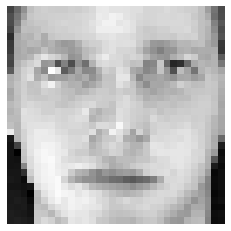

In [ ]:
# Display a single example.
show_single_face(data[0, :])

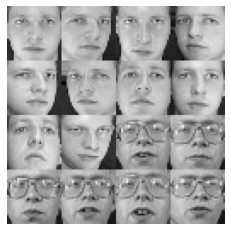

In [ ]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

First, normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments.

A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [ ]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares (13 Marks in Total)
### 3.1 Implementation (5 Marks, Easy)
Now, you need to implement the function `l2_rls_train` below.

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [ ]:
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

def l2_rls_train(data, labels, param_lambda
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """

    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Expand X with a column of ones.
    X_tilde = np.c_[ np.expand_dims(np.ones(X.shape[0]), axis = 1), X ]

    # Compute the coefficient vector.
    if param_lambda != 0:
        w = np.linalg.inv(X_tilde.T @ X_tilde + param_lambda * np.eye(X_tilde.shape[1])) @ X_tilde.T @ y
    else:
        #Compute Moore-Penrose inverses (pseudoinverses) based on the comparison between nr of rows and columns
        if(X_tilde.shape[1] > X_tilde.shape[0]):
            w = X_tilde.T @ np.linalg.inv(X_tilde @ X_tilde.T) @ y
        else:
            w = np.linalg.inv(X_tilde.T @ X_tilde) @ X_tilde.T @ y


    # Return model parameters.
    return w


Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [ ]:
def l2_rls_predict(w, data):
    """
    A summary of your function goes here.

    data: type and description of "data"
    w: type and description of "w"

    Returns: type and description of the returned variable(s).
    """

   # Compute the prediction.
    X = data
    X_tilde = np.c_[ np.expand_dims(np.ones(X.shape[0]), axis = 1), X ]
    predicted_y = X_tilde @ w

    return predicted_y

#### Report

Explain briefly the knowledge supported your implementation and your design step by step.

### 3.2 Experiments (2 experiments to be implemented)

Use your implemented functions to perform the following experiments. Experiment 1 is compulsory. Between Experiment 2 and Experiment 3, choose one as you like.

#### Experiment 1: Binary Classification (4 Marks, Normal)

Start with a binary classification to classify face images for subjects “1” and “30”.

Train three classifiers:
<br>Classifier 1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
<br>Classifier 2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
<br>Classifier 3. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [ ]:

#Get all the labels from 1 and 30 and append them to a list
labels_1 = labels[np.where(labels == 1)]
labels_30 = labels[np.where(labels == 30)]
all_labels = np.append(labels_1, labels_30)

def classify_subj(y1, y30, threshold, all_labels = all_labels):

    #Make data split between training and testing
    tr_ind, te_ind = partition_data(all_labels, num_per_class=3)


    #Add 280 to all values at position 3 or above to match subject 30 indices both in training set and testing set
    for idx in range(0,len(tr_ind)):
        if(idx >=3):
            tr_ind[idx] += 280

    for idx in range(0,len(te_ind)):
        if(idx >=7):
            te_ind[idx] += 280

    np.random.shuffle(tr_ind)
    np.random.shuffle(te_ind)

    #Get the actual data and assign them to the labels passed as parameters
    tr_data = data[tr_ind, :]
    tr_label = labels[tr_ind]
    tr_label = np.where(tr_label == 1, y1, y30)
    te_data = data[te_ind, :]
    te_label = labels[te_ind]
    te_label = np.where(te_label == 1, y1, y30)

    #Compute the weights
    weights = l2_rls_train(tr_data, tr_label, 0)

    #Compute training prediction and map them to actual labels comparing them to a threshold
    predicted_values_tr = l2_rls_predict(weights, tr_data)
    predicted_values_tr = np.where(predicted_values_tr <= threshold, y1, y30)

    #Compute testing prediction and map them to actual labels comparing them to a threshold
    predicted_values_te = l2_rls_predict(weights, te_data)
    predicted_values_te = np.where(predicted_values_te <= threshold, y1, y30)

    #Calculate the accuracy on training set by comparing them to the ground truth labels
    #Devide by 6 because we have 6 training images, 3 for each subject
    counter = np.count_nonzero(predicted_values_tr != tr_label)
    train_error = counter / 6

    #Calculate the accuracy on testing set by comparing them to the ground truth labels
    #Devide by 14 because we have 14 testing images, 7 for each subject
    counter = np.count_nonzero(predicted_values_te != te_label)
    test_error = counter / 14

    return test_error, train_error


#Initialize train error and test error for first classifier so we can view performance
#This will use label -1 for subject 1 and label 1 for subject 30, compare against a threshold of 0
train_error_list_1 = []
test_error_list_1 = []

for i in range(0, 50):
    test_error, train_error = classify_subj(-1, 1, 0)
    train_error_list_1.append(train_error)
    test_error_list_1.append(test_error)

Repeat the same experiment for classifier 2.

In [ ]:
#Initialize train error and test error for second classifier so we can view performance
#This will use label 0 for subject 1 and label 1 for subject 30, compare against a threshold of 0.5
train_error_list_2 = []
test_error_list_2 = []
for i in range(0, 50):
    test_error, train_error = classify_subj(0, 1, 0.5)
    train_error_list_2.append(train_error)
    test_error_list_2.append(test_error)

Repeat the same experiment for classifier 3.

In [ ]:
#Initialize train error and test error for third and last classifier so we can view performance
#This will use label 1 for subject 1 and label 30 for subject 30, compare against a threshold of 15.5
train_error_list_3 = []
test_error_list_3 = []
for i in range(0, 50):
    test_error, train_error = classify_subj(1, 30, 15.5)
    train_error_list_3.append(train_error)
    test_error_list_3.append(test_error)

Print out the mean and the std values of the test errors of the three classifiers.

In [ ]:
def print_my_results(train_err, test_err, nr):
    print("--------------------For Classifier " + str(nr) + "--------------------")
    print("|+   Train error mean: " + str(np.mean(train_err)))
    print("|+   Train error standard deviation: " + str(np.std(train_err)))
    print("|+   Test error mean: " + str(np.mean(test_err)))
    print("|+   Test error standard deviation: " + str(np.std(test_err)) + "\n")


#Print the mean of all errors recorded along with standard deviations both on training and testing for each classifier
print_my_results(train_error_list_1, test_error_list_1, 1)
print_my_results(train_error_list_2, test_error_list_2, 2)
print_my_results(train_error_list_3, test_error_list_3, 3)

--------------------For Classifier 1--------------------
|+   Train error mean: 0.0
|+   Train error standard deviation: 0.0
|+   Test error mean: 0.06142857142857142
|+   Test error standard deviation: 0.0795523188132906

--------------------For Classifier 2--------------------
|+   Train error mean: 0.0
|+   Train error standard deviation: 0.0
|+   Test error mean: 0.058571428571428566
|+   Test error standard deviation: 0.08414031041501269

--------------------For Classifier 3--------------------
|+   Train error mean: 0.0
|+   Train error standard deviation: 0.0
|+   Test error mean: 0.03571428571428571
|+   Test error standard deviation: 0.06267831705280087



#### Report

Explain the classification steps. Does changing the class labels impact the model performance? Explain why it does/doesn't impact.  What training accuracies do you obtain with your linear classifier? Analyse the reason.

#### Experiment 2: Multi-class Classification (4 Marks, Normal)

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$.

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples.

Write your code below and make sure it compiles.

In [ ]:
# Your code goes here
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

In [ ]:
# Your code goes here

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

In [ ]:
# Your code goes here

#### Report

Explain the classification steps. How do you pick the most difficult and easiest subjects to classify,  analyse the results.

#### Experiment 3: Face Completion (4 Marks, Normal)

The task is to predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [ ]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

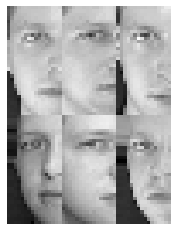

In [ ]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [ ]:
def mape_fct(actual, predicted):

    subtracted_array = list()
    for img_right, img_right_pred in zip(actual, predicted):
        subtracted_array.append(abs((img_right - img_right_pred) / img_right))

    sum_MAPE = np.sum(subtracted_array)
    mape = sum_MAPE / (len(actual) * 512)
    return mape


#Get training and testing indices with a 50-50 split, assign the data and perform the separation of the faces
tr_ind, te_ind = partition_data(labels, num_per_class = 5)
tr_data = data[tr_ind, :]
te_data = data[te_ind, :]
left_train, right_train = split_left_right(tr_data)
left_test, right_test = split_left_right(te_data)

#Calculate the weights but instead of using the labels we will use the right side of the image
weights = l2_rls_train(left_train, right_train, 0)

#Predict right side for training set and join the predicted right with the given left one
predicted_train = l2_rls_predict(weights, left_train)
full_img_pred_train = join_left_right(left_train, predicted_train)

#Predict right side for testing set and join the predicted right with the given left one
predicted_test = l2_rls_predict(weights, left_test)
full_img_pred_test = join_left_right(left_test, predicted_test)


#Compute the mean absolute percentage error both for training and testing
print("------------------RESULTS------------------")
print("|+    Train Error MAPE: " + str(mape_fct(right_train, predicted_train)))
print("|+    Test error MAPE: " + str(mape_fct(right_test, predicted_test)))

------------------RESULTS------------------
|+    Train Error MAPE: 1.3071732604453725e-12
|+    Test error MAPE: 0.23035811474876997


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

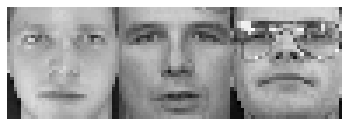

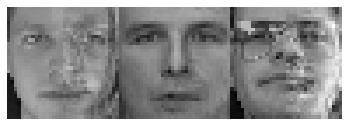

In [ ]:
#We have 40 subjects and our split gives 5 images per subject, so 200 indices
#Get 3 random indices
rand_indices = np.random.randint(200, size = 3)

#Get the actual and the predicted data value of those 3 indices
actual = te_data[rand_indices , :]
pred = full_img_pred_test[rand_indices, :]

#Display them
show_faces(actual, num_per_row = 3)
show_faces(pred, num_per_row = 3)

#### Report

Analyse results of face completion model, how well your model performed, how it can be improved?


## 4. Gradient descent for training linear least squares model (5 Marks in Total, Normal)

Now, implement the function `lls_gd_train` below.

`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [ ]:


def lls_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """

    # This is just to be consistent with the lecture notes.
    X, y = data, labels

    # Expand X with a column of ones.
    X_tilde = np.c_[ np.expand_dims(np.ones(X.shape[0]), axis = 1), X ]

    # Weight initialization
    w = np.linalg.inv(X_tilde.T @ X_tilde) @ X_tilde.T @ y * 0

    #Initialzie cost_all and w_all
    cost_all = []
    w_all = []

    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y

        #Compute the cost (here it is done matrix wise, do it in a try in case it overflows)
        D = X_tilde @ w - y
        try:
            cost = 0.5 * (D @ D)
            cost_all.append(cost)
        except:
            pass

        # Weight update using learning rate and the updated gradient
        w = w - learning_rate * gd

        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)

    # Return model parameters.
    return cost_all, w_all

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles.

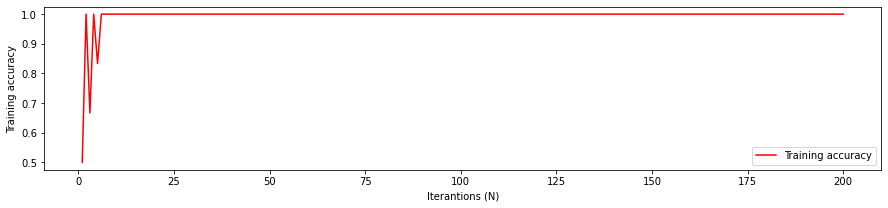

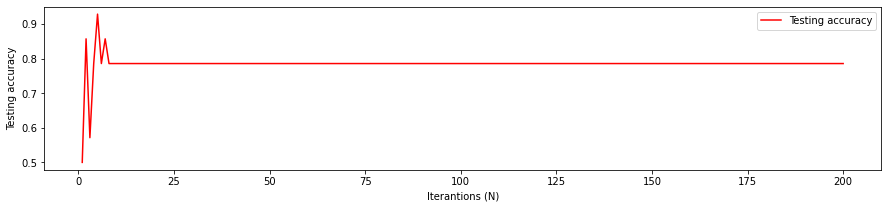

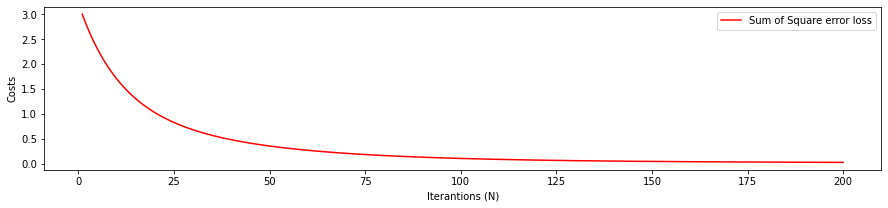

In [ ]:
#Get the labels and partition the data, subject 1 and 30 are preserved for consistency
labels_1 = labels[np.where(labels == 1)]
labels_30 = labels[np.where(labels == 30)]
all_labels = np.append(labels_1, labels_30)
tr_ind, te_ind = partition_data(all_labels, num_per_class=3)

#Add 280 to all values at position 3 or above to match subject 30 indices both in training set and testing set
for idx in range(0,len(tr_ind)):
    if(idx >=3):
        tr_ind[idx] += 280

for idx in range(0,len(te_ind)):
    if(idx >=7):
        te_ind[idx] += 280

np.random.shuffle(tr_ind)
np.random.shuffle(te_ind)

#Assign the data based on the indices and relabel them to -1 and 1 (commonly used labelling in Machine Learning)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
tr_label = np.where(tr_label == 1, -1, 1)
te_data = data[te_ind, :]
te_label = labels[te_ind]
te_label = np.where(te_label == 1, -1, 1)

#Compute weights from training data and training labels using a learning rate of 10^-3 and 200 iterations
cost_all, w_all = lls_gd_train(tr_data, tr_label, pow(10, -3), 200)

train_acc = []

#For all weight vectors computed predict on training data, assign them to actual labels and compute accuracy
for weight in w_all:
    predicted_values_tr = l2_rls_predict(weight, tr_data)
    predicted_values_tr = np.where(predicted_values_tr <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_tr == tr_label)
    acc = counter / 6
    train_acc.append(acc)


test_acc = []

#For all weight vectors computed predict on testing data, assign them to actual labels and compute accuracy
for weight in w_all:
    predicted_values_te = l2_rls_predict(weight, te_data)
    predicted_values_te = np.where(predicted_values_te <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_te == te_label)
    acc = counter / 14
    test_acc.append(acc)


#Visualize the results
plt1 = plt.figure(figsize=(15, 3))
integers_1_to_200 = np.arange(1, 201)


#Training accuracies plot
plt.plot(integers_1_to_200, train_acc, label = 'Training accuracy', color = 'red')

plt.xlabel('Iterantions (N)')
plt.ylabel('Training accuracy')
plt.legend()

plt.show()

#Testing accuracies plot
plt1 = plt.figure(figsize=(15, 3))
plt.plot(integers_1_to_200, test_acc, label = 'Testing accuracy', color = 'red')

plt.xlabel('Iterantions (N)')
plt.ylabel('Testing accuracy')
plt.legend()

plt.show()

#Cost function plot
plt1 = plt.figure(figsize=(15, 3))
plt.plot(integers_1_to_200, cost_all, label = 'Sum of Square error loss', color = 'red')

plt.xlabel('Iterantions (N)')
plt.ylabel('Costs')
plt.legend()

plt.show()


Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles.

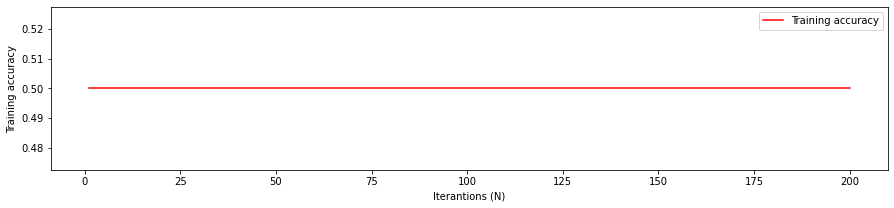

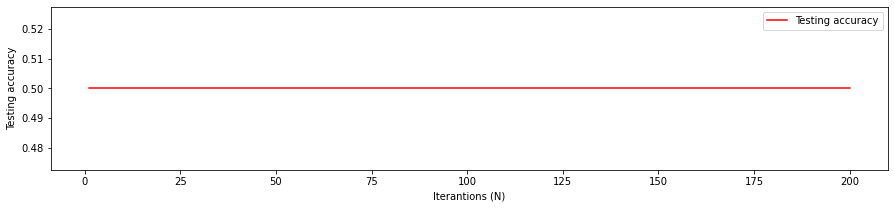

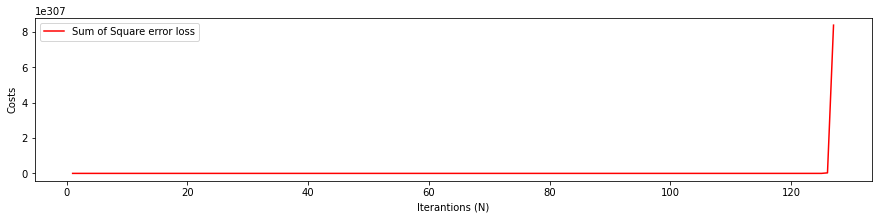

In [ ]:
#Perform again on higher learning rate and same data to be able to see differences

#Compute weights from training data and training labels using a learning rate of 10^-2 and 200 iterations
cost_all, w_all = lls_gd_train(tr_data, tr_label, pow(10, -2), 200)
train_acc = []


#For all weight vectors computed predict on training data, assign them to actual labels and compute accuracy
for weight in w_all:
    predicted_values_tr = l2_rls_predict(weight, tr_data)
    predicted_values_tr = np.where(predicted_values_tr <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_tr == tr_label)
    acc = counter / 6
    train_acc.append(acc)


test_acc = []

#For all weight vectors computed predict on test data, assign them to actual labels and compute accuracy
for weight in w_all:
    predicted_values_te = l2_rls_predict(weight, te_data)
    predicted_values_te = np.where(predicted_values_te <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_te == te_label)
    acc = counter / 14
    test_acc.append(acc)

#Visualize the results

plt1 = plt.figure(figsize=(15, 3))
integers_1_to_200 = np.arange(1, 201)


#Training accuracies plot
plt.plot(integers_1_to_200, train_acc, label = 'Training accuracy', color = 'red')

plt.xlabel('Iterantions (N)')
plt.ylabel('Training accuracy')
plt.legend()

plt.show()

#Testing accuracies plot
plt1 = plt.figure(figsize=(15, 3))
plt.plot(integers_1_to_200, test_acc, label = 'Testing accuracy', color = 'red')

plt.xlabel('Iterantions (N)')
plt.ylabel('Testing accuracy')
plt.legend()

plt.show()

#Cost function plot
plt1 = plt.figure(figsize=(15, 3))
plt.plot(np.arange(1, len(cost_all) + 1), cost_all, label = 'Sum of Square error loss', color = 'red')

plt.xlabel('Iterantions (N)')
plt.ylabel('Costs')
plt.legend()

plt.show()

#### Report

How did you choose the learning rate and iteration number, explain your results.

## 5. Compare with stochastic gradient descent training (7 Marks In Total)
### 5.1 SGD Implementation (2 Marks, Normal)
Replace the gradient descent approach that you did in 4 with a stochastic gradient descent approach. Your new implementation can be named as `lls_sgd_train`. You can adopt the similar implementation template as used in your `lls_gd_train` function.

In [ ]:
def lls_sgd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
    A summary of your function goes here.

    data: type and description of "data"
    labels: type and description of "labels"

    Returns: type and description of the returned variable(s).
    """

    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    # Expand X with a column of ones.
    X_tilde = np.c_[ np.expand_dims(np.ones(X.shape[0]), axis = 1), X ]

    # Weight initialization
    w = np.zeros((X_tilde.shape[1], 1))

    cost_all = []
    w_all = []

    # GD update of weights
    for i in range(N):

        #Select a random sample for each iteration
        j = np.random.randint(0, len(X_tilde))

        # cost and gradient descent of the linear least squares model
        gd = X_tilde[[j], :].T @ X_tilde[[j], :] @ w - X_tilde[[j], :].T * y[j]


        try:
            #Compute the cost (here it is done sample wise, do it in a try in case it overflows)
            cost = 0
            for idx in range(0, len(X_tilde)):
                cost = cost + pow((w.T @ X_tilde[idx] - y[idx]), 2)

            cost_all.append(cost)
        except:
            pass

        # Weight update using the learning rate and the update of the stochastic gradient descent
        w = w - learning_rate * gd


            # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)

    # Return model parameters.
    return cost_all, w_all




### 5.2 Experiment Design (5 Marks, Hard)
Design and implement an appropriate experiment to demonstrate the perforamnce and behaviour difference between gradient descent and stochastic gradient descent.


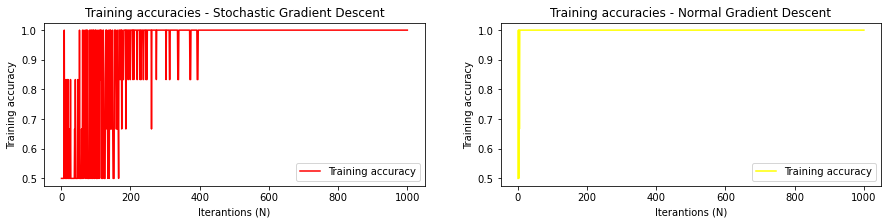

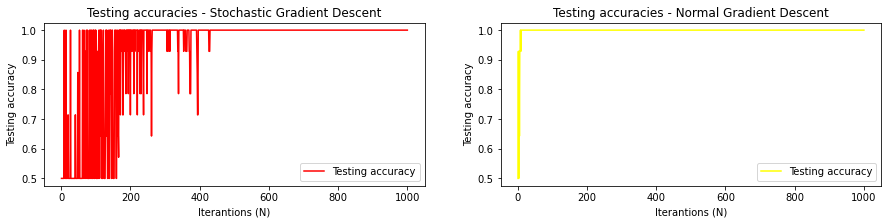

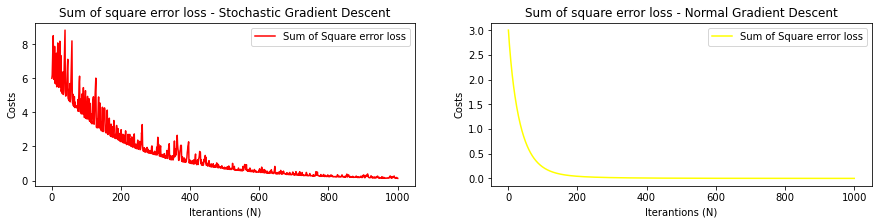

In [ ]:
#Again choose subject 1 and 30 for consistency over all experiments
labels_1 = labels[np.where(labels == 1)]
labels_30 = labels[np.where(labels == 30)]
all_labels = np.append(labels_1, labels_30)
tr_ind, te_ind = partition_data(all_labels, num_per_class=3)

#Add 280 to all values at position 3 or above to match subject 30 indices both in training set and testing set
for idx in range(0,len(tr_ind)):
    if(idx >=3):
        tr_ind[idx] += 280

for idx in range(0,len(te_ind)):
    if(idx >=7):
        te_ind[idx] += 280

np.random.shuffle(tr_ind)
np.random.shuffle(te_ind)

#Assign the data based on the indices and relabel them to -1 and 1 (commonly used labelling in Machine Learning)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
tr_label = np.where(tr_label == 1, -1, 1)
te_data = data[te_ind, :]
te_label = labels[te_ind]
te_label = np.where(te_label == 1, -1, 1)

#First experiment performed on 1000 iterations
#Compute weights using SGD
cost_all_sgd, w_all_sgd = lls_sgd_train(tr_data, tr_label, pow(10, -3), 1000)

train_acc_sgd = []

#For all weight vectors computed by SGD predict on training data, assign them to actual labels and compute accuracy
for weight in w_all_sgd:
    predicted_values_tr = l2_rls_predict(weight, tr_data)
    predicted_values_tr = np.where(predicted_values_tr <= 0 , -1, 1)
    predicted_values_tr = predicted_values_tr.reshape((1, len(predicted_values_tr)))
    counter = np.count_nonzero(predicted_values_tr == tr_label)
    acc = counter / 6
    train_acc_sgd.append(acc)

test_acc_sgd = []

#For all weight vectors computed by SGD predict on testing data, assign them to actual labels and compute accuracy
for weight in w_all_sgd:
    predicted_values_te = l2_rls_predict(weight, te_data)
    predicted_values_te = np.where(predicted_values_te <= 0 , -1, 1)
    predicted_values_te = predicted_values_te.reshape((1, len(predicted_values_te)))
    counter = np.count_nonzero(predicted_values_te == te_label)
    acc = counter / 14
    test_acc_sgd.append(acc)


#Compute weights using GD
cost_all_gd, w_all_gd = lls_gd_train(tr_data, tr_label, pow(10, -3), 1000)

train_acc = []

#For all weight vectors computed by GD predict on training data, assign them to actual labels and compute accuracy
for weight in w_all_gd:
    predicted_values_tr = l2_rls_predict(weight, tr_data)
    predicted_values_tr = np.where(predicted_values_tr <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_tr == tr_label)
    acc = counter / 6
    train_acc.append(acc)


test_acc = []

#For all weight vectors computed by GD predict on testing data, assign them to actual labels and compute accuracy
for weight in w_all_gd:
    predicted_values_te = l2_rls_predict(weight, te_data)
    predicted_values_te = np.where(predicted_values_te <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_te == te_label)
    acc = counter / 14
    test_acc.append(acc)



integers_1_to_200 = np.arange(1, 1001)

#Plot SGD training accuracies alongside with GD training accuracies
plt1 = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(integers_1_to_200, train_acc_sgd, label = 'Training accuracy', color = 'red')
plt.title("Training accuracies - Stochastic Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Training accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(integers_1_to_200, train_acc, label = 'Training accuracy', color = 'yellow')
plt.title("Training accuracies - Normal Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Training accuracy')
plt.legend()


plt.show()

#Plot SGD testing accuracies alongside with GD testing accuracies
plt1 = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(integers_1_to_200, test_acc_sgd, label = 'Testing accuracy', color = 'red')
plt.title("Testing accuracies - Stochastic Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Testing accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(integers_1_to_200, test_acc, label = 'Testing accuracy', color = 'yellow')
plt.title("Testing accuracies - Normal Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Testing accuracy')
plt.legend()

plt.show()

#Plot SGD cost function alongside with GD cost function
plt1 = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(cost_all_sgd) + 1), cost_all_sgd, label = 'Sum of Square error loss', color = 'red')
plt.title("Sum of square error loss - Stochastic Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Costs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(cost_all_gd) + 1), cost_all_gd, label = 'Sum of Square error loss', color = 'yellow')
plt.title("Sum of square error loss - Normal Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Costs')
plt.legend()

plt.show()


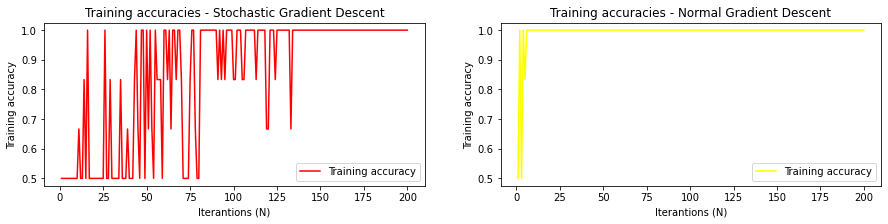

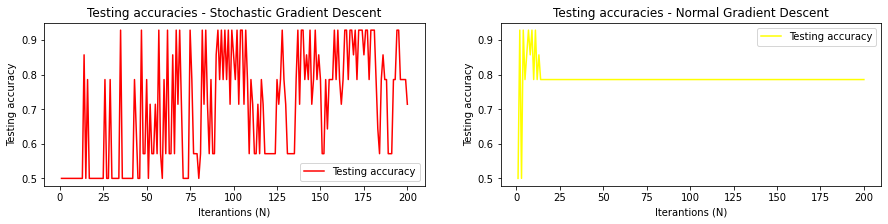

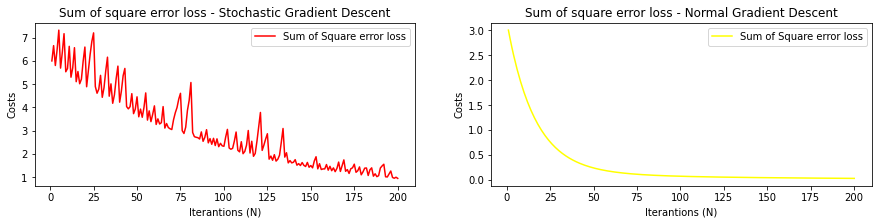

In [ ]:
#Perform the same experiment but this time on a smaller number of iterations (200)

#Again choose subject 1 and 30 for consistency over all experiments
labels_1 = labels[np.where(labels == 1)]
labels_30 = labels[np.where(labels == 30)]
all_labels = np.append(labels_1, labels_30)
tr_ind, te_ind = partition_data(all_labels, num_per_class=3)

#Add 280 to all values at position 3 or above to match subject 30 indices both in training set and testing set
for idx in range(0,len(tr_ind)):
    if(idx >=3):
        tr_ind[idx] += 280

for idx in range(0,len(te_ind)):
    if(idx >=7):
        te_ind[idx] += 280

np.random.shuffle(tr_ind)
np.random.shuffle(te_ind)

#Assign the data based on the indices and relabel them to -1 and 1 (commonly used labelling in Machine Learning)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
tr_label = np.where(tr_label == 1, -1, 1)
te_data = data[te_ind, :]
te_label = labels[te_ind]
te_label = np.where(te_label == 1, -1, 1)

#First experiment performed on 200 iterations
#Compute weights using SGD
cost_all_sgd, w_all_sgd = lls_sgd_train(tr_data, tr_label, pow(10, -3), 200)

train_acc_sgd = []

#For all weight vectors computed by SGD predict on training data, assign them to actual labels and compute accuracy
for weight in w_all_sgd:
    predicted_values_tr = l2_rls_predict(weight, tr_data)
    predicted_values_tr = np.where(predicted_values_tr <= 0 , -1, 1)
    predicted_values_tr = predicted_values_tr.reshape((1, len(predicted_values_tr)))
    counter = np.count_nonzero(predicted_values_tr == tr_label)
    acc = counter / 6
    train_acc_sgd.append(acc)

test_acc_sgd = []

#For all weight vectors computed by SGD predict on testing data, assign them to actual labels and compute accuracy
for weight in w_all_sgd:
    predicted_values_te = l2_rls_predict(weight, te_data)
    predicted_values_te = np.where(predicted_values_te <= 0 , -1, 1)
    predicted_values_te = predicted_values_te.reshape((1, len(predicted_values_te)))
    counter = np.count_nonzero(predicted_values_te == te_label)
    acc = counter / 14
    test_acc_sgd.append(acc)

#Compute weights using GD
cost_all_gd, w_all_gd = lls_gd_train(tr_data, tr_label, pow(10, -3), 200)

train_acc = []

#For all weight vectors computed by GD predict on training data, assign them to actual labels and compute accuracy
for weight in w_all_gd:
    predicted_values_tr = l2_rls_predict(weight, tr_data)
    predicted_values_tr = np.where(predicted_values_tr <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_tr == tr_label)
    acc = counter / 6
    train_acc.append(acc)


test_acc = []

#For all weight vectors computed by GD predict on testing data, assign them to actual labels and compute accuracy
for weight in w_all_gd:
    predicted_values_te = l2_rls_predict(weight, te_data)
    predicted_values_te = np.where(predicted_values_te <= 0 , -1, 1)
    counter = np.count_nonzero(predicted_values_te == te_label)
    acc = counter / 14
    test_acc.append(acc)



integers_1_to_200 = np.arange(1, 201)

#Plot SGD training accuracies alongside with GD training accuracies
plt1 = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(integers_1_to_200, train_acc_sgd, label = 'Training accuracy', color = 'red')
plt.title("Training accuracies - Stochastic Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Training accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(integers_1_to_200, train_acc, label = 'Training accuracy', color = 'yellow')
plt.title("Training accuracies - Normal Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Training accuracy')
plt.legend()


plt.show()

#Plot SGD testing accuracies alongside with GD testing accuracies
plt1 = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(integers_1_to_200, test_acc_sgd, label = 'Testing accuracy', color = 'red')
plt.title("Testing accuracies - Stochastic Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Testing accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(integers_1_to_200, test_acc, label = 'Testing accuracy', color = 'yellow')
plt.title("Testing accuracies - Normal Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Testing accuracy')
plt.legend()

plt.show()

#Plot SGD cost function alongside with GD cost function
plt1 = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(cost_all_sgd) + 1), cost_all_sgd, label = 'Sum of Square error loss', color = 'red')
plt.title("Sum of square error loss - Stochastic Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Costs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(cost_all_gd) + 1), cost_all_gd, label = 'Sum of Square error loss', color = 'yellow')
plt.title("Sum of square error loss - Normal Gradient Descent")
plt.xlabel('Iterantions (N)')
plt.ylabel('Costs')
plt.legend()

plt.show()


#### Report  

Explain in the report your experiment design, comparative result analysis and interpretation of obtained results. Try to be thorough in your analysis.

#### Remember that all graphs should have axis labels and a title.